In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import seaborn as sns
import scipy.special as sp
import sklearn.datasets as datasets
import sklearn.linear_model as lm
import sklearn.ensemble as en
import sklearn.tree as tree
from sklearn.model_selection import train_test_split
import econml
import importlib
import pyreadr

#### data generation packages
import strawman_edge
import strawman_center
import all_linear

#### main packages
import characterize
import estimate_atte as est
import learn_w as learn
import black

importlib.reload(est)
importlib.reload(learn)

import warnings

warnings.filterwarnings("ignore")

%load_ext jupyter_black
sns.set(font_scale=1.25, style="whitegrid")
np.random.seed(0)

In [224]:
outcome_cols = ["opioiduse12", "opioiduse24"]
treatment_col = "medicine_assigned"
discrete_cov = ["xrace", "mar", "sex"]

baseline_harmonized = pd.read_csv(
    "/Users/harshparikh/Library/CloudStorage/OneDrive-JohnsHopkins/MOUD_data/updated_data/ctn0094/drv/clean_patients_with_relapse_wide.csv",
    index_col=0,
)

# baseline_harmonized = baseline_harmonized.rename(
#     columns={col: col.split(".")[1] for col in baseline_harmonized.columns}
# ).set_index("who")

stacked_list = []
for i in range(1, 6):
    stacked_list.append(
        pd.read_csv(
            "/Users/harshparikh/Library/CloudStorage/OneDrive-JohnsHopkins/MOUD_data/stacked_list_%d.csv"
            % (i),
            index_col=0,
        )
    )
df = stacked_list[0]

df_tedsa = df.loc[df["trialdata"] == 0]

## TEDS-A vs CTN 27

In [226]:
ct94 = baseline_harmonized.loc[(baseline_harmonized["project"] == 27)]
outcome94 = ct94[outcome_cols]

common_cols = set.intersection(set(df_tedsa.columns), set(ct94.columns))

df_tedsa_cc = df_tedsa[common_cols]
df_tedsa_cc["S"] = 0
ct94_cc = ct94[common_cols].fillna(0)
ct94_cc["med_met"] = (
    (ct94[treatment_col] == "met").astype(int).fillna(0)
)  # methadone = 1 and bupenorphine = 0
ct94_cc["sex"] = (ct94["sex"] == "male").astype(int)  # male = 1 and female = 0

# invert age categories
df_tedsa_cc["age"].replace(
    {
        1: 13,
        2: 16,
        3: 18,
        4: 22,
        5: 27,
        6: 32,
        7: 37,
        8: 42,
        9: 47,
        10: 52,
        11: 60,
        12: 68,
    },
    inplace=True,
)

ct94_cc["S"] = 1
ct94_cc = ct94_cc.astype(int)

ct94_cc = ct94_cc.join(outcome94, how="inner")

ct94_cc.groupby(by="med_met").mean()[outcome_cols]

,opioiduse12,opioiduse24
med_met,,
0,0.629380,0.750674
1,0.553875,0.650284


In [391]:
print(
    (
        100
        * (
            ct94_cc.loc[ct94_cc["med_met"] == 1, outcome_cols[1]].mean()
            - ct94_cc.loc[ct94_cc["med_met"] == 0, outcome_cols[1]].mean()
        ),
        1.96
        * 100
        * np.sqrt(
            ct94_cc.loc[ct94_cc["med_met"] == 1, outcome_cols[1]].var()
            / ct94_cc.loc[ct94_cc["med_met"] == 1, outcome_cols[1]].shape[0]
            + ct94_cc.loc[ct94_cc["med_met"] == 0, outcome_cols[1]].var()
            / ct94_cc.loc[ct94_cc["med_met"] == 0, outcome_cols[1]].shape[0]
        ),
    )
)

(-10.03903005722031, 5.123408063788226)


In [402]:
df_primary = pd.concat([df_tedsa_cc.sample(frac=1, replace=False), ct94_cc])

df_ = df_primary.drop(columns=[outcome_cols[0]]).fillna(0)

outcome = outcome_cols[1]
treatment = "med_met"
sample = "S"
data = df_
S = df_[sample]  # indicator for the sample
Y = df_[outcome]  # outcome variable
T = df_[treatment]  # indicator for the treatment

data_dummy = pd.get_dummies(data, columns=["xrace", "mar"])
data_dummy["Education(12y)"] = (data_dummy["edu"] >= 2).astype(int)
data_dummy.drop(columns=["edu", "mar_0"], inplace=True)
data_dummy.rename(
    columns={
        "sex": "Sex",
        "age": "Age",
        "ivdrug": "IV Drug Use",
        "bamphetamine30_base": "Hx Amphetamine",
        "bbenzo30_base": "Hx Benzo",
        "bcannabis30_base": "Hx Cannabis",
        "xrace_1": "White",
        "xrace_2": "Black",
        "xrace_3": "Hispanic",
        "xrace_4": "Other Race",
        "mar_1": "Married",
        "mar_2": "Divorced/Separated",
        "mar_3": "Single",
    },
    inplace=True,
)

X = data_dummy.drop(columns=[outcome, treatment, sample])  # pre-treatment covariates

In [393]:
importlib.reload(learn)
df_v, pi, pi_m, mu_1_m, mu_0_m, e_m, data2 = learn.estimate_dml(
    data_dummy, outcome, treatment, sample, crossfit=3
)

print(df_v.join(S).groupby(by="S").mean())
print(df_v.join(S).mean()["te"] * 100)
print(np.sqrt(df_v.join(S).mean()["te_sq"] / df_v.shape[0]) * 100)

In [404]:
importlib.reload(learn)
# D, w_tree, testing_data = learn.tree_opt(data, outcome, treatment, sample, leaf_proba=1)
D_rash, D_forest, w_forest, rashomon_set, f, testing_data = learn.forest_opt(
    data=data_dummy,
    outcome=outcome,
    treatment=treatment,
    sample=sample,
    leaf_proba=1,
    num_trees=3000,
    vote_threshold=1 / 2,
    # top_k_trees=True,
    # k=50,
)

baseline_loss = np.sqrt(np.sum(D_forest["vsq"]) / ((D_forest.shape[0] ** 2)))
print("Baseline Objective:%.4f" % (baseline_loss))

Fold 0
Fold 1
Fold 2
Fold 3
Fold 4
ATE Est: -0.0072
leaf                  0.500000
IV Drug Use           0.001443
Sex                   0.014135
Age                   0.000300
Hx Cannabis           0.007435
Hx Benzo              0.015683
Hx Amphetamine        0.003966
White                 0.015461
Black                 0.048430
Hispanic              0.011989
Other Race            0.020980
Married               0.064671
Divorced/Separated    0.065335
Single                0.091032
Education(12y)        0.139140
dtype: float64
Baseline Objective:0.0683


Number of Selected Trees: 1338
1


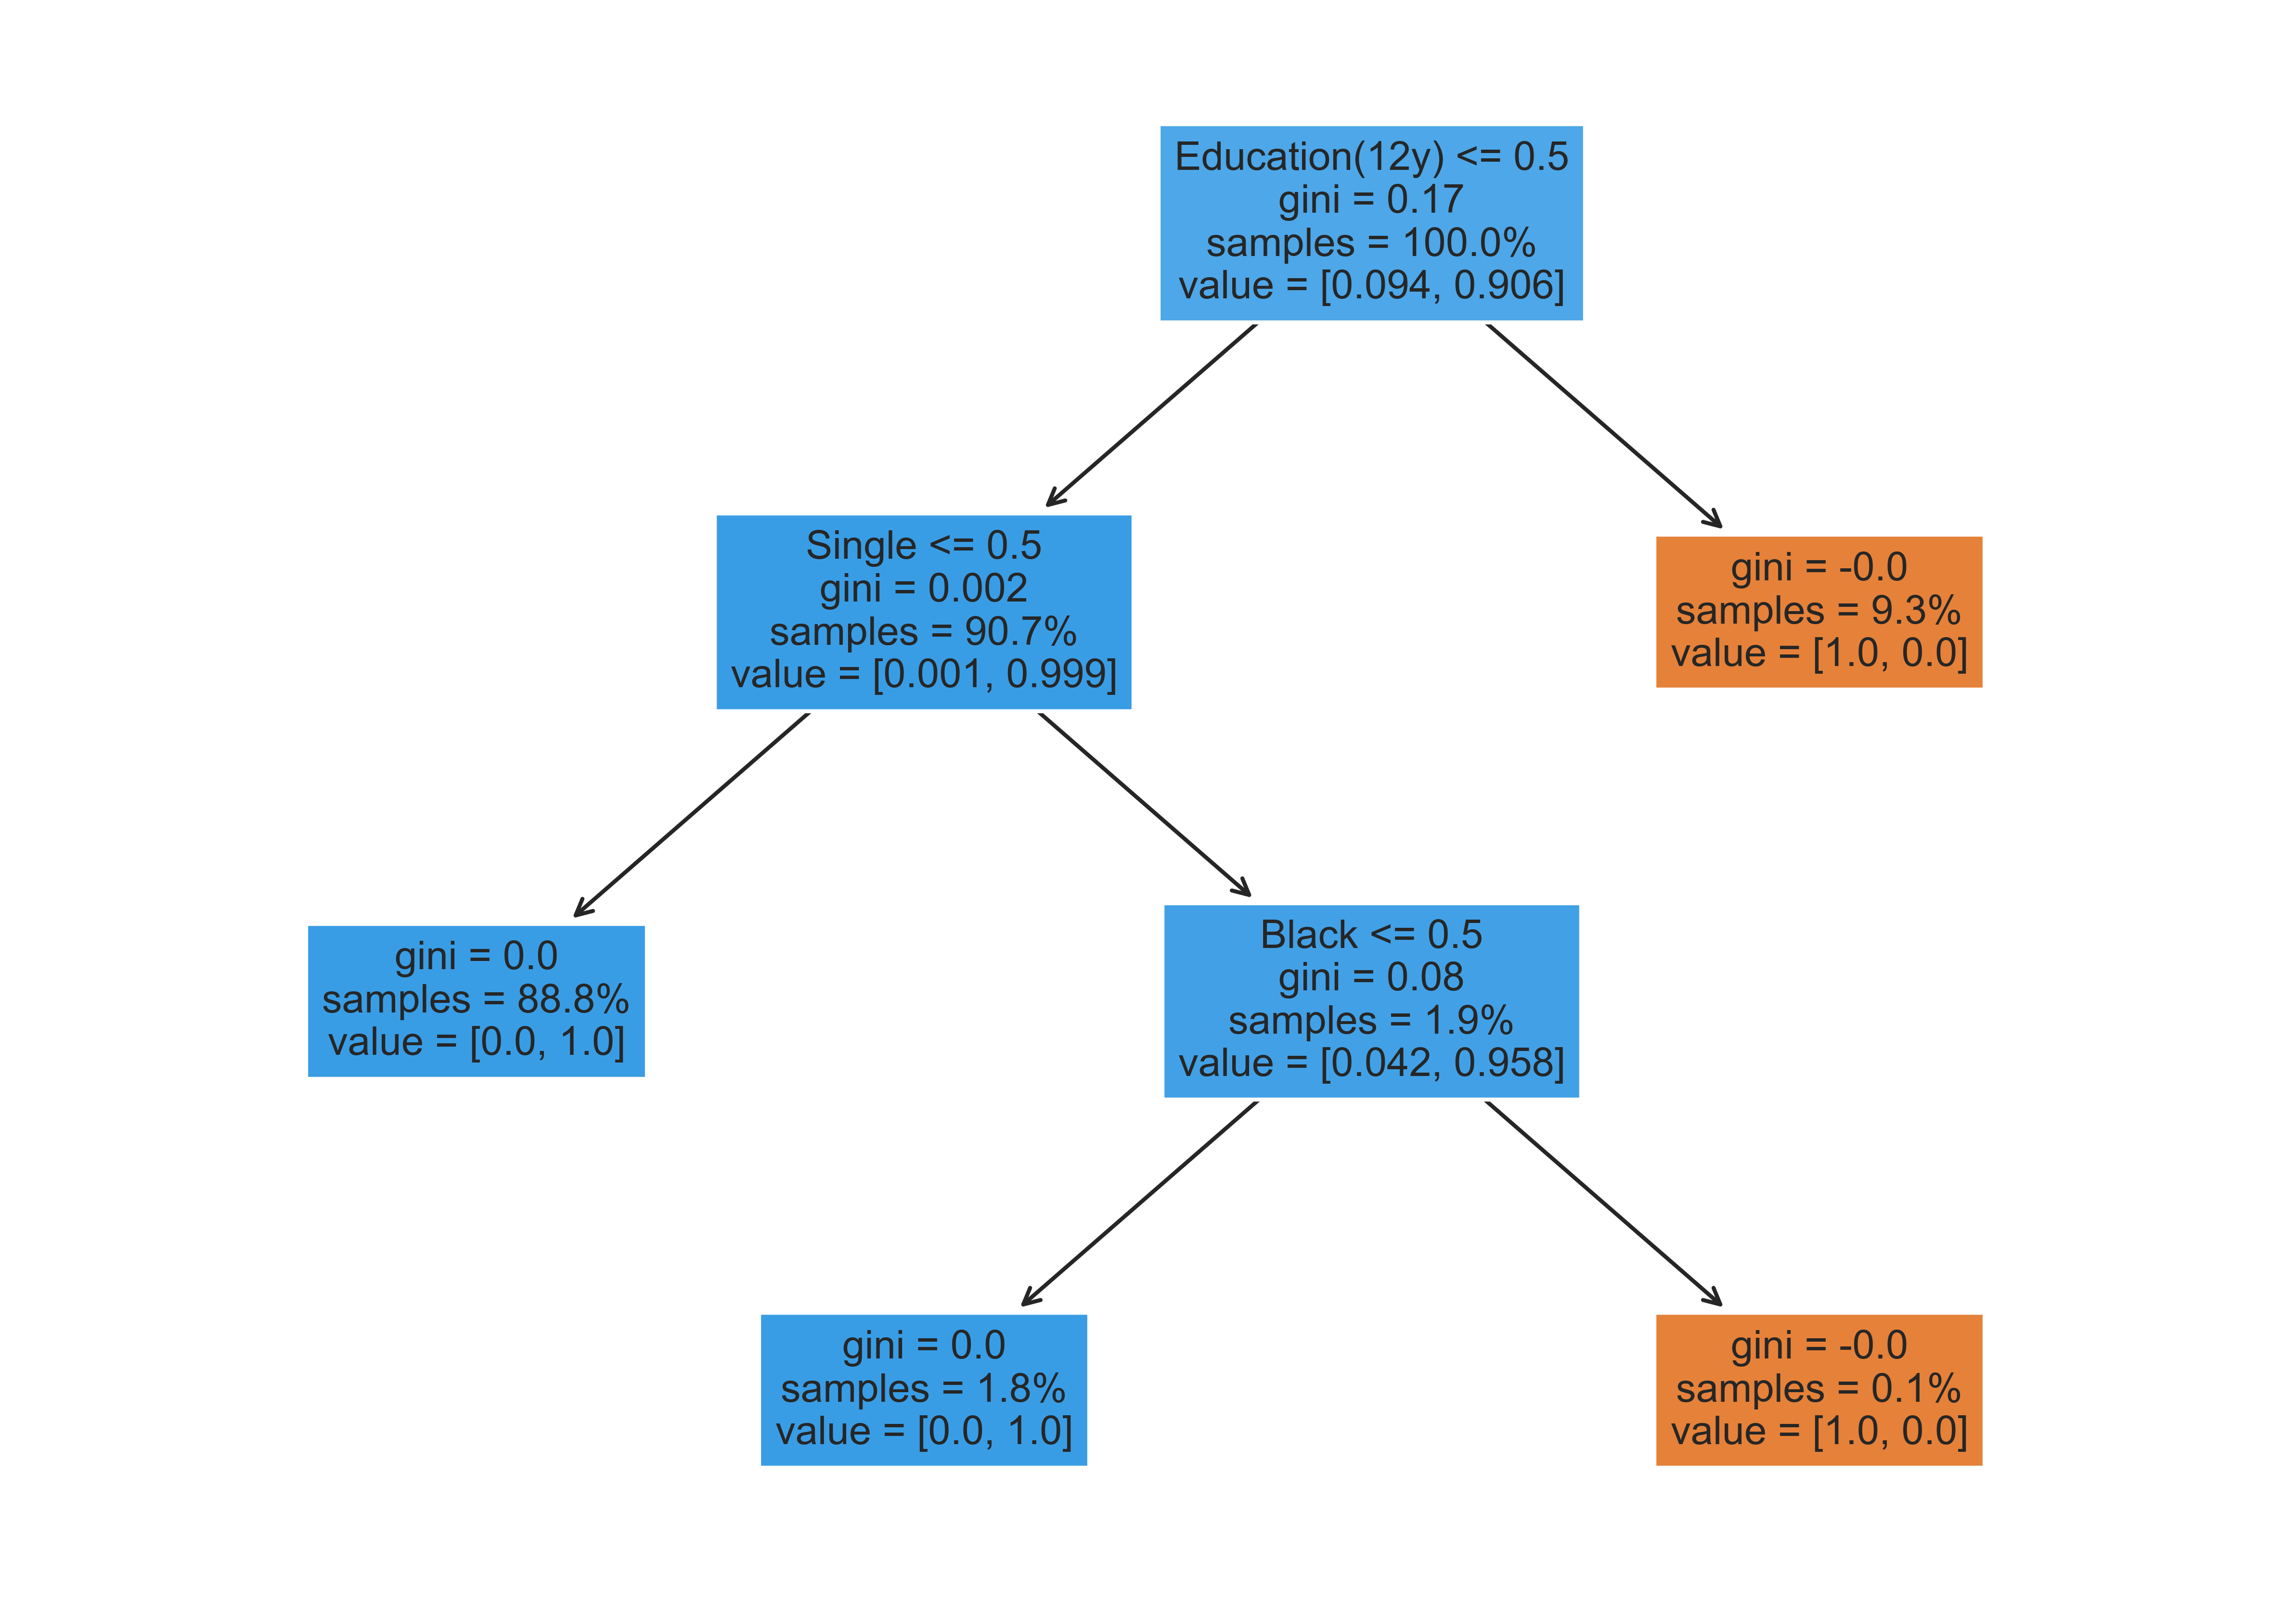

In [438]:
w_rash = [
    "w_tree_%d" % (i)
    for i in range(len(w_forest))
    if w_forest[i]["local objective"] < baseline_loss
]
print("Number of Selected Trees: %d" % (len(w_rash)))
avg_votes = (D_forest[w_rash].mean(axis=1) >= 0.5).astype(int)

np.random.seed(42)
explainer = en.AdaBoostClassifier(
    base_estimator=tree.DecisionTreeClassifier(max_depth=3)
).fit(X.loc[avg_votes.index], avg_votes)

print(len(explainer.estimators_))

num_trees = min(3, len(explainer.estimators_))
fig, ax = plt.subplots(nrows=num_trees, figsize=(10, 7 * num_trees), dpi=600)
for i in range(num_trees):
    if num_trees == 1:
        tree.plot_tree(
            explainer.estimators_[i],
            feature_names=X.columns,
            ax=ax,
            filled=True,
            fontsize=10,
            proportion=True,
        )
    else:
        tree.plot_tree(
            explainer.estimators_[i],
            feature_names=X.columns,
            ax=ax[i],
            filled=True,
            fontsize=10,
            proportion=True,
        )
plt.savefig("tedsa_ctn27.pdf", dpi=600)

In [443]:
D_forest.groupby(by=["Education(12y)", "Single", "Black"]).mean()[["v", "vsq", "l(X)"]]

v          vsq       l(X)
Education(12y) Single Black                                   
0              0      0      -0.010063     0.046842  15.072296
                      1       0.039718     0.161585   6.958730
               1      0       0.299198     8.081176   0.000762
                      1       7.423684    55.218752   0.000309
1              0      0       0.678505    18.964595   0.000701
                      1       3.259223    23.276866   0.000245
               1      0      -0.179703    54.455149   0.000245
                      1     -26.527419  1407.023404   0.000097

In [444]:
print(
    r"Pre Pruning, SATE: %.2f ± %.2f"
    % (
        100
        * (
            df_.loc[(df_[sample] == 1) * (df_[treatment] == 1), outcome].mean()
            - df_.loc[(df_[sample] == 1) * (df_[treatment] == 0), outcome].mean()
        ),
        100
        * 1.96
        * (
            df_.loc[(df_[sample] == 1) * (df_[treatment] == 1), outcome].sem()
            + df_.loc[(df_[sample] == 1) * (df_[treatment] == 0), outcome].sem()
        ),
    )
)

print(
    r"Pre Pruning, ATTE: %.2f ± %.2f"
    % (
        100 * D_rash["v"].mean(),
        100 * 1.96 * np.sqrt(D_rash["vsq"].mean() / D_rash["w_opt"].count()),
    )
)

print(
    r"Post Pruning, ATTE: %.2f ± %.2f"
    % (
        100 * D_rash["v"].loc[D_rash["w_opt"] == 1].mean(),
        100
        * 1.96
        * np.sqrt(
            D_rash["vsq"].loc[D_rash["w_opt"] == 1].mean() / D_rash["w_opt"].sum()
        ),
    )
)

Pre Pruning, SATE: -10.04 ± 7.18
Pre Pruning, ATTE: -0.72 ± 13.39
Post Pruning, ATTE: 0.05 ± 2.69


In [445]:
D_forest.to_csv("tedsa_analysis_forest_opt.csv")
D_rash.to_csv("tedsa_analysis_forest_rashomon_opt.csv")